# COGS 108 - EDA Checkpoint

# Names

- Crystal Zhan
- Akil Selvan Rajendra Janarthanan 
- Kristen Prescaro
- Kristine Thipatima
- Ethan Dinh-Luong

<a id='research_question'></a>
# Research Question

How did the addition of the Fairy type Pokemon change competitive battling?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning

## Cleaning Informational Data (Pokemon Moves, Pokemon Types)

The list of moves is in a semi-structed JSON file, which we needed to clean up so we only had the relevant information about the moves. 

In [2]:
moves = pd.read_json("Pokedex and Moves/data/moves.json")
moves.head()

,10000000voltthunderbolt,absorb,accelerock,acid,acidarmor,aciddownpour,acidspray,acrobatics,acupressure,aerialace,...,workup,worryseed,wrap,wringout,xscissor,yawn,zapcannon,zenheadbutt,zingzap,zippyzap
num,719,71,709,51,151,628,491,512,367,332,...,526,388,35,378,404,281,192,428,716,729
accuracy,True,100,100,100,True,True,100,100,True,True,...,True,100,90,100,100,True,50,90,100,100
basePower,195,20,40,40,0,1,40,55,0,60,...,0,0,15,0,80,0,120,80,80,80
category,Special,Special,Physical,Special,Status,Physical,Special,Physical,Status,Physical,...,Status,Status,Physical,Special,Physical,Status,Special,Physical,Physical,Physical
isNonstandard,Past,NaN,NaN,NaN,NaN,Past,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Past,NaN,NaN,NaN,NaN,NaN,LGPE


As can be seen, the names of the moves are the column names and the variables are the row names. However, we want it the other way around, with the move names as the index. 

We also only want the move name and the move type, so we remove all other variables. 

Next, we reset the index so there are index numbers and rename the index column to be called move.

Now, our move dataset is clean. 

In [3]:
# switching the column and row names 
moves = moves.T

# removing all columns except move name & type
moves = moves.loc[:,["name", "type"]]

#resetting the index numbers
moves = moves.reset_index()

#renaming index to be called move 
moves.rename(columns = {"index":"move"}, inplace=True)
moves.head()

,move,name,type
0,10000000voltthunderbolt,"10,000,000 Volt Thunderbolt",Electric
1,absorb,Absorb,Grass
2,accelerock,Accelerock,Rock
3,acid,Acid,Poison
4,acidarmor,Acid Armor,Poison


Now, we apply the same cleaning steps with the list of Pokemon. 

However, there is an extra step of removing any Mega or Gmax form Pokemon, as our Pokemon Showdown dataset doesn't include them, nor would they affect the usage of Pokemon based on type. 

In [4]:
pokemon = pd.read_json("Pokedex and Moves/data/pokedex.json")

#takes column name and row name and flips them
pokemon = pokemon.T 
pokemon = pokemon.iloc[0:1155, :]

#deletes all columns except for name and types
pokemon = pokemon.loc[:,["name", "types"]]
pokemon = pokemon.reset_index()

#renames index to be pokemon
pokemon.rename(columns = {"index":"pokemon"}, inplace=True)

#drop rows that contain the partial string "gmax or mega" in the pokemon column
pokemon = pokemon[~pokemon.pokemon.str.contains("gmax")]
pokemon = pokemon[~pokemon.name.str.contains("-Mega")]

pokemon.head()


,pokemon,name,types
0,bulbasaur,Bulbasaur,"[Grass, Poison]"
1,ivysaur,Ivysaur,"[Grass, Poison]"
2,venusaur,Venusaur,"[Grass, Poison]"
5,charmander,Charmander,[Fire]
6,charmeleon,Charmeleon,[Fire]


The next step for the Pokemon list is to split the type column into two parts, as some Pokemon have two types, while others have one. For those with one type, we will put null for the 2nd type. 

In [5]:
type1 = []
type2 = []

#loop through the list of pokemon and puts their types in their own columns
#puts None if there's no secondary type
for x in pokemon["types"]:
    type1.append(x[0])
    if (len(x) == 2):
        type2.append(x[1])
    else:
        type2.append(None)

pokemon["types"] = type1
pokemon["type2"] = type2
pokemon.head()


,pokemon,name,types,type2
0,bulbasaur,Bulbasaur,Grass,Poison
1,ivysaur,Ivysaur,Grass,Poison
2,venusaur,Venusaur,Grass,Poison
5,charmander,Charmander,Fire,None
6,charmeleon,Charmeleon,Fire,None


## Pokemon Showdown Battle Stats

The data given by Pokemon Showdown is several semi-structured JSON format files, where cleaning was needed in every file to read the data into a usable format. 

*The cleaning process exampled below was repeated for all other JSON files.*

Unnecessary data prior to our analysis was removed where data was null.

In [6]:
raw = pd.read_json("Pokemon Usage/September/raw/gen8/gen8ou-0.json")
df = raw[raw['data'].notna()]['data']
df

Mr. Mime-Galar    {'Moves': {'': 32.0, 'healingwish': 226.0, 'bl...
Eevee             {'Moves': {'': 197.0, 'rest': 7.0, 'mudslap': ...
Torracat          {'Moves': {'': 1.0, 'firespin': 20.0, 'leechli...
Poliwrath         {'Moves': {'': 58.0, 'counter': 48.0, 'liquida...
Emolga            {'Moves': {'': 2.0, 'eerieimpulse': 47.0, 'ris...
                                        ...                        
Shedinja          {'Moves': {'': 578.0, 'absorb': 11.0, 'falsesw...
Wishiwashi        {'Moves': {'': 67.0, 'liquidation': 393.0, 'be...
Sneasel           {'Moves': {'counter': 3.0, 'beatup': 9.0, 'bli...
Hitmontop         {'Moves': {'': 208.0, 'detect': 89.0, 'quickgu...
Kingdra           {'Moves': {'': 57.0, 'icywind': 32.0, 'liquida...
Name: data, Length: 440, dtype: object

To narrow down the data desired for our analysis, the following criteria were used to filter out the data:
- Pokemon with at least 2% usage
- Each Pokemon's Top 6 Moves

Additionally, each dataframe includes 4 more columns identifying which JSON file the data originated from, denoted by **Gen**, **Format**, **Rating**, and **Recent** given in the first few rows of the JSON file.

In [7]:
### Dictionary to make the DataFrame
top_mons = {}

### Saves the Pokemon as Indexes
ix = list(df.index)

### For each Observation
for row in range(len(df)):

    ### At least 2% Usage
    if df[row]['usage'] >= .02:

        ### Pokemon Name
        mon = ix[row]

        ### Finds the Top 6 Moves
        top_6 = list(dict(sorted(df[row]['Moves'].items(), key=lambda item: item[1], reverse=True)))[:6]
        
        ### Saves info to dictionary
        top_mons[mon] = [top_6, df[row]['usage']]

### Output DataFrame
cleaned = pd.DataFrame.from_dict(top_mons, orient = 'index').rename(columns = {0:"Moves", 1:"Usage"})

### Format, Gen, Rating Variables
metagame = raw.loc['metagame'][0]
gen = metagame[3]
format_name = metagame[4:]
rating = raw.loc["cutoff"][0]

### Adding the Variables to the DF
cleaned["Gen"] = gen
cleaned["Format"] = format_name
cleaned["Min Rating"] = rating
cleaned.head()


,Moves,Usage,Gen,Format,Min Rating
Landorus-Therian,"[earthquake, uturn, stealthrock, knockoff, tox...",0.304108,8,ou,0.0
Blissey,"[softboiled, seismictoss, toxic, teleport, thu...",0.084829,8,ou,0.0
Slowbro,"[scald, teleport, slackoff, futuresight, icebe...",0.057747,8,ou,0.0
Crawdaunt,"[aquajet, knockoff, crabhammer, swordsdance, c...",0.028303,8,ou,0.0
Urshifu-Rapid-Strike,"[surgingstrikes, closecombat, aquajet, uturn, ...",0.129478,8,ou,0.0


## Joining the Datasets

### Showdown Usage with Moves

Firstly, we imported all the cleaned data from the prior section that was applied to all JSON files.

In [8]:
### Importing Usage DFs and Merging Them
recentdf = pd.read_csv("Pokemon Usage/SeptemberData.csv",index_col=0).rename(columns = {'index':"name"})
olddf =  pd.read_csv("Pokemon Usage/OldData.csv",index_col=0).rename(columns = {'index':"name"})
usagedf = recentdf.merge(olddf, how='outer')
print(usagedf.shape)
usagedf.head()

(5916, 7)


,name,Moves,Usage,Gen,Format,Min Rating,Recent
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1


The **Moves** column deceptively looks cleaned in a list format, but upon closer observation, it is actually a *string* representation of a list.

In [9]:
type(usagedf["Moves"][0])

str

Addressing this, we will convert the string into a list by stripping the list representation and splitting the string by commas. Afterwards, we can proceed with standardizing the moves by its type.

In [10]:
### Importing Moves DF
movesdf = pd.read_csv("Pokedex and Moves/moves.csv", index_col=0).set_index('move')

### Standardize the Moves
def standardize_moves(df):

    ### List Representations of each Column
    type1 = []
    type2 = []
    type3 = []
    type4 = []
    type5 = []
    type6 = []

    ### List of Pointers to Column Lists
    type_list = [type1, type2, type3, type4, type5, type6]

    ### For Each Row
    for row in range(len(df["Moves"])):

        ### Strip the List Borders and Create a List by Splitting on Commas in the String
        moves = df["Moves"][row].strip('][').split(', ')

        ### Tracks which Column Each Move Belongs to
        list_num = 0

        ### For Each Column
        for each in range(6):

            ### If a Pokemon has less than 6 moves, return nan
            if each >= len(moves):
                move_type = np.nan
                type_list[list_num].append(move_type)
                list_num += 1

            else:
                ### Removes Outer Apostrophes, if any
                string = moves[each].strip("'")

                ### If a Popular Move is an Empty Slot, return nan
                if (string) == "":
                    move_type = np.nan
                    type_list[list_num].append(move_type)
                    list_num += 1
                else:

                    ### Find Move in Move DF containing Type
                    move_type = movesdf.loc[string]['type']

                    ### Add to Column
                    type_list[list_num].append(move_type)

                    ### Change Column
                    list_num += 1

    ### Piecing Everything Together
    df["Type 1"] = type_list[0]
    df["Type 2"] = type_list[1]
    df["Type 3"] = type_list[2]
    df["Type 4"] = type_list[3]
    df["Type 5"] = type_list[4]
    df["Type 6"] = type_list[5]

    return df

usagemovesdf = standardize_moves(usagedf)
usagemovesdf.head()

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2,Type 3,Type 4,Type 5,Type 6
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Normal,Ground,Rock,Psychic,Water
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Ground,Rock,Water,Ice,Ice,Normal
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,Dark,Ground,Ghost,Psychic,Fire
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Rock,Bug,Electric,Psychic,Psychic,Psychic
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,Dark,Steel,Ice,Rock,Normal


### Showdown Usage with Pokemon Types

As opposed to the complexity of joining moves with usage, simply joining the Pokemon Types DF stats on the Showdown Usage on **name** will add two new columns **Type 1** and **Type 2** to the Showdown Usage DF.

In [11]:
### Import Usage Data
usagedf = recentdf.merge(olddf, how='outer')

### Import Pokemon Types Data
pokedexdf = pd.read_csv("Pokedex and Moves/pokemon.csv", index_col=0).set_index('name')[['types','type2']]

### Left Join Usage DF with Pokemon Types DF on "name" while renaming the additional columns
usagetypesdf = usagedf.join(pokedexdf, on="name").rename(columns={'types': "Type 1", "type2": "Type 2"})
usagetypesdf

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Psychic
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Water,Ground
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,NaN
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Psychic,NaN
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,NaN
...,...,...,...,...,...,...,...,...,...
5911,Charizard,"['solarbeam', 'fireblast', 'hurricane', 'airsl...",0.030482,8.0,ubers,0.0,0,Fire,Flying
5912,Shuckle,"['stickyweb', 'stealthrock', 'encore', 'finalg...",0.045773,8.0,ubers,0.0,0,Bug,Rock
5913,Hatterene,"['mysticalfire', 'psychic', 'dazzlinggleam', '...",0.026064,8.0,ubers,0.0,0,Psychic,Fairy
5914,Zacian-Crowned,"['behemothblade', 'playrough', 'swordsdance', ...",0.921806,8.0,ubers,0.0,0,Fairy,Steel


# Data Analysis & Results (EDA)

Before modeling our data, we want to extract the necessary labeled variables that we are analyzing into a quantitative variable, specifically the move types. We "standardize" these categoricals by counting how many moves within a Pokemon's Top 6 Moves are supereffective against either Fairy or Dragon Types and assign them to two new columns: **SE Dragon** and **SE Fairy**.

In [2]:
### Finds all Super Effective Moves in the column
def SE_moves(move_type, df, col, binary=False):

    ### Checks if Moves are supereffective against Dragon
    if move_type == "Dragon":
        SE_moves = ["Ice","Dragon"]
    
    ### Checks if Moves are supereffective against Fairy
    else:
        SE_moves = ["Steel","Poison"]

    ### Creates New Variable
    is_SE = None

    ### For each Super Effective Move
    for each in SE_moves:

        ### First Iteration
        if is_SE is None:
            
            ### Finds Supereffective Moves and marks them as 1
            is_SE = (df[col] == each)*1
        else:
            ### Keeps count of Supereffective Moves
            is_SE += (df[col] == each)*1
    
    ### Returns Column with Count of Supereffective Moves per Pokemon
    return is_SE

### Function that checks through all columns and types
def find_all_SE(df, binary = False):
    types = ["Dragon", "Fairy"]
    col = ["Type 1", "Type 2", "Type 3", "Type 4", "Type 5", "Type 6"]
    SE_col = ["SE Dragon", "SE Fairy"]

    for each in types:

        all_SE = None

        for col_name in col:

            if all_SE is None:
                all_SE = SE_moves(each, df, col_name)
            else:
                all_SE += SE_moves(each, df, col_name)

        ### Changes to binary results, if specified
        if binary:
            all_SE = (all_SE > 0) * 1
        df[SE_col[0]] = all_SE
        SE_col = SE_col[1:]
    
    return df

usagemovesdf = find_all_SE(usagemovesdf)
usagemovesdf.head()

NameError: name 'usagemovesdf' is not defined

In [13]:
#takes the combined df of types of pokemon + their usages and splits them into usage of Dragon type and non Dragon type Pokemon

def df(generation, format, type):
    #makes new df that only has Pokemon of wanted generation + format
    df = usagetypesdf[(usagetypesdf["Gen"] == generation) & (usagetypesdf["Format"] == format)]

    #new df that only has wanted type
    types = df.loc[((df['Type 1']==type) | (df['Type 2']==type)), :]
    
    #finds usage of the type
    typesusage = types['Usage'].sum()

    #new df that has any pokemon that's not the wanted type
    nottype = df.loc[((df['Type 1']!=type) & (df['Type 2']!=type)), :]

    #finds usage of not type
    nottypeusage = nottype['Usage'].sum()
    
    #new array with usages to be returned
    usagedf = [typesusage, nottypeusage]

    return usagedf

First, let us see how the usage of dragon type pokemon was affected by the addition of fairy type pokemon. We can also at how often fairy type pokemon were used in each format to see how popular they were.

In [14]:
#finds the usage of dragon/fairy type in ubers format in each generation

dgen4ubers = df (4, "ubers", "Dragon")
dgen5ubers = df (5, "ubers", "Dragon")
dgen6ubers = df (6, "ubers", "Dragon")
dgen7ubers = df (7, "ubers", "Dragon")
dgen8ubers = df (8, "ubers", "Dragon")

fgen6ubers = df (6, "ubers", "Fairy")
fgen7ubers = df (7, "ubers", "Fairy")
fgen8ubers = df (8, "ubers", "Fairy")

In [15]:
#finds the usage of dragon/fairy type in ou format in each generation

dgen4ou = df (4, "ou", "Dragon")
dgen5ou = df (5, "ou", "Dragon")
dgen6ou = df (6, "ou", "Dragon")
dgen7ou = df (7, "ou", "Dragon")
dgen8ou = df (8, "ou", "Dragon")

fgen6ou = df (6, "ou", "Fairy")
fgen7ou = df (7, "ou", "Fairy")
fgen8ou = df (8, "ou", "Fairy")

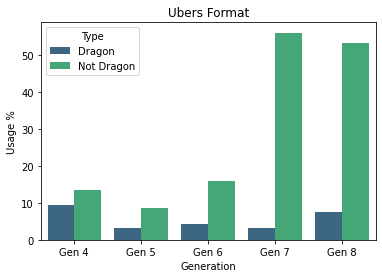

In [16]:
#Using the values above, we made a dataframe with the usage % of dragon types and non-dragon types across generations in Ubers format.
ubdragondf2= pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4', 'Gen 5', 'Gen 5', 'Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Dragon', 'Not Dragon', 'Dragon', 'Not Dragon','Dragon', 'Not Dragon','Dragon', 'Not Dragon', 'Dragon', 'Not Dragon'],
        "Usage %": [dgen4ubers[0], dgen4ubers[1], dgen5ubers[0], dgen5ubers[1], dgen6ubers[0], dgen6ubers[1], dgen7ubers[0], dgen7ubers[1], dgen8ubers[0], dgen8ubers[1]],
    },
)
# We then used this dataframe to create a barplot comparing dragon and not dragon usage in Ubers format.
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ubdragondf2,
            palette='viridis'
           ).set_title("Ubers Format");


In Ubers format, the % of dragon type usage shows a gradual decline until the increase of usage in generation 8. Meanwhile, the usage % of non-dragon types declines a bit in generation 5 but spikes up in generations 7 and 8.

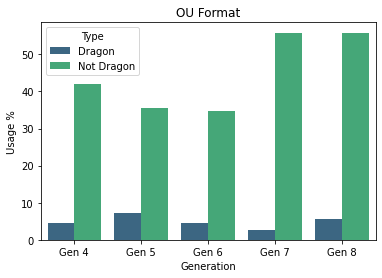

In [17]:
#Similarly, we created a dataframe containing the usage % of dragon types and not dragon types across generations in OU format. 
oudragondf2= pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4', 'Gen 5', 'Gen 5', 'Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Dragon', 'Not Dragon', 'Dragon', 'Not Dragon','Dragon', 'Not Dragon','Dragon', 'Not Dragon', 'Dragon', 'Not Dragon'],
        "Usage %": [dgen4ou[0], dgen4ou[1], dgen5ou[0], dgen5ou[1], dgen6ou[0], dgen6ou[1], dgen7ou[0], dgen7ou[1], dgen8ou[0], dgen8ou[1]],
    },
)
#We used this dataframe to create a barplot comparing dragon and not dragon usage in OU format.
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=oudragondf2,
            palette='viridis'
           ).set_title("OU Format");


In the OU format, the % of not Dragon types decreases until generation 7, where it goes to its highest and stays at that level in generation 8. On the other hand, the % of Dragon types fluctuates, decreasing from 6 -> 7, then back up again in generation 8.

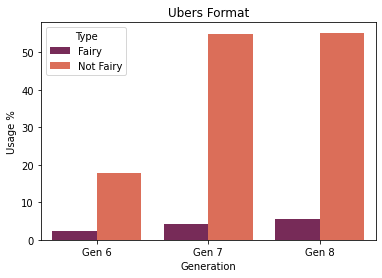

In [18]:
#We created a dataframe containing the usage % of fairy types and not fairy types across generations in Ubers format.
ubFairydf2= pd.DataFrame(
    {
        "Generation" : ['Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Fairy', 'Not Fairy', 'Fairy', 'Not Fairy','Fairy', 'Not Fairy'],
        "Usage %": [fgen6ubers[0], fgen6ubers[1], fgen7ubers[0], fgen7ubers[1], fgen8ubers[0], fgen8ubers[1]],
    },
)
#We used the dataframe above to create a barplot that compares fairy and not fairy usage in Ubers format
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ubFairydf2,
            palette='rocket'
           ).set_title("Ubers Format");

In the Ubers format, the % of not Fairy types goes up from generation 6 to 7, then stays the same between 7 and 8. The % of Fairy types goes up very slightly, although that could be noise.

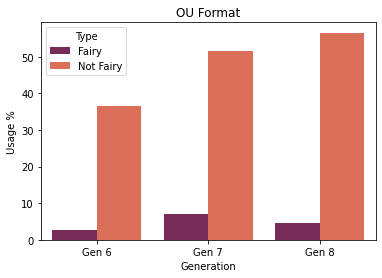

In [19]:
#We also created a dataframe containing the usage % of fairy types and not fairy types across generations in OU format.
ouFairydf2= pd.DataFrame(
    {
        "Generation" : ['Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Fairy', 'Not Fairy', 'Fairy', 'Not Fairy','Fairy', 'Not Fairy'],
        "Usage %": [fgen6ou[0], fgen6ou[1], fgen7ou[0], fgen7ou[1], fgen8ou[0], fgen8ou[1]],
    },
)
#This dataframe was used to create a barplot comparing fairy and not fairy usage in OU format.
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ouFairydf2,
            palette='rocket'
           ).set_title("OU Format");

In each generation in the OU format, the % of not Fairy types goes up, while Fairy type increases in generation 7 and declines a bit in generation 8.

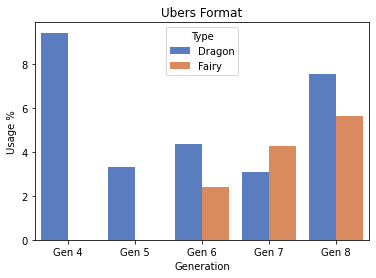

In [20]:
#Here we have made a new dataframe that contains the usage % of dragon types and fairy types across generations in Ubers format.
ubdragonfairydf= pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4', 'Gen 5', 'Gen 5', 'Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Dragon', 'Fairy', 'Dragon', 'Fairy','Dragon', 'Fairy','Dragon', 'Fairy', 'Dragon', 'Fairy'],
        "Usage %": [dgen4ubers[0], 0, dgen5ubers[0], 0, dgen6ubers[0], fgen6ubers[0], dgen7ubers[0], fgen7ubers[0], dgen8ubers[0], fgen8ubers[0]],
    },
)
#Using this dataframe, we created a barplot comparing dragon and fairy usage in Ubers format.
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ubdragonfairydf,
            palette='muted'
           ).set_title("Ubers Format");

The number of Dragon type Pokemon fluctuates between each generation, although for each generation that Fairy type is in, usage seems to go up. In generation 6 and 8, there are more Dragon than fairy types, although the reverse is true for generation 7.

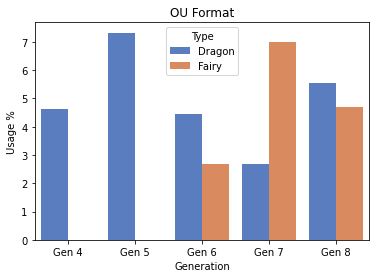

In [21]:
#We also created a new dataframe that contains the usage % of dragon types and fairy types across generations in ou format.
oudragonfairydf= pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4', 'Gen 5', 'Gen 5', 'Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Dragon', 'Fairy', 'Dragon', 'Fairy','Dragon', 'Fairy','Dragon', 'Fairy', 'Dragon', 'Fairy'],
        "Usage %": [dgen4ou[0], 0, dgen5ou[0], 0, dgen6ou[0], fgen6ou[0], dgen7ou[0], fgen7ou[0], dgen8ou[0], fgen8ou[0]],
    },
)
# We used this dataframe to create a barplot that compares dragon and fairy usage in OU format.
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=oudragonfairydf,
            palette='muted'
           ).set_title("OU Format");

In OU format, both dragon and fairy type usage seem to fluctuate. The usage % of dragon types decreases in generation 6, when fairy types are introduced, and it continues to decline in generation 7 as fairy type usage increases significantly. Generation 8 sees an increase in dragon type usage while fairy type usage decreases.

Now, lets look at how the movepools of pokemon changed to reflect the addition of fairy type pokemon in generation 6.

In [22]:
usagemovesdf.head()

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2,Type 3,Type 4,Type 5,Type 6,SE Dragon,SE Fairy
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Normal,Ground,Rock,Psychic,Water,0,1
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Ground,Rock,Water,Ice,Ice,Normal,2,0
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,Dark,Ground,Ghost,Psychic,Fire,0,0
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Rock,Bug,Electric,Psychic,Psychic,Psychic,0,0
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,Dark,Steel,Ice,Rock,Normal,1,1


In [23]:
# We are only looking at ou and ubers formats
usagemovesdf2 = usagemovesdf[(usagemovesdf['Format'] == 'ou') | (usagemovesdf['Format'] == 'ubers')] 

# We are looking at the % of moves SE against Dragons in both tiers
# The reason we are calculating usage % this way is: usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Dragon'].sum() tells us how many SE moves were used in the 4th gen and (usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Dragon'].count() *6) tells us how many total moves were used in the 4th gen. We can simply multiply by 6 here because we are only looking at the top 6 moves! We use the same logic for calculating the rest of the SE percentages.
gen4SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Dragon'].count() *6)
gen5SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Dragon'].count() *6)
gen6SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Dragon'].count() *6)
gen7SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Dragon'].count() *6)
gen8SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Dragon'].count() *6)

# We are looking at the % of moves SE against Dragons in just Ubers
gen4SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen5SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen6SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen7SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen8SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

# We are looking at the % of moves SE against Dragons in just OU
gen4SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen5SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen6SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen7SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen8SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)




print(gen4SEDragons, gen5SEDragons, gen6SEDragons, gen7SEDragons, gen8SEDragons)

gen4SEDragonsUbers

0.11412429378531073 0.12471264367816091 0.09877354358300482 0.09765715611227094 0.08610435252771019


0.15517241379310345

Text(0.5, 1.0, 'Moves SE against dragon in Generations 4-8')

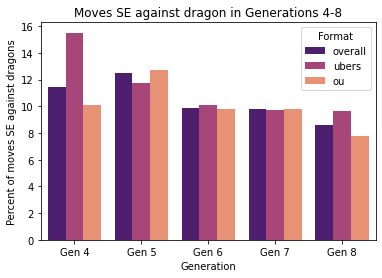

In [24]:
# EDA time woo

# We make a new dataframe with the % of moves SE against a Dragon from the numbers we calculated above.
seDragonsDf = pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4','Gen 4', 'Gen 5', 'Gen 5','Gen 5', 'Gen 6', 'Gen 6','Gen 6','Gen 7', 'Gen 7','Gen 7','Gen 8', 'Gen 8', 'Gen 8'],
        "Format": ['overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou','overall', 'ubers', 'ou'],
        "Percent of moves SE against dragons": [gen4SEDragons, gen4SEDragonsUbers, gen4SEDragonsOU, gen5SEDragons, gen5SEDragonsUbers, gen5SEDragonsOU, gen6SEDragons, gen6SEDragonsUbers, gen6SEDragonsOU, gen7SEDragons, gen7SEDragonsUbers, gen7SEDragonsOU, gen8SEDragons, gen8SEDragonsUbers, gen8SEDragonsOU],
    },
)

# change decimal into a percentage
seDragonsDf["Percent of moves SE against dragons"] = seDragonsDf["Percent of moves SE against dragons"].apply(lambda x: x*100)

sns.barplot(x="Generation", 
            y="Percent of moves SE against dragons", 
            hue="Format", 
            data=seDragonsDf,
            palette='magma'
           ).set_title("Moves SE against dragon in Generations 4-8")



As we would expect, the number of ice type and dragon type moves went down a noticable amount with the introduction of fairy types in gen 6. This is because Fairy type attacks were a new viable counter to dragon types so players had more options to choose from and chose ice and dragon types much less. 

In [25]:
# Here, we repeat the same process for moves that are SE against the Fairy type.
# We are looking at the % of moves SE against Fairy in both tiers
gen4SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Fairy'].count() *6)
gen5SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Fairy'].count() *6)
gen6SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Fairy'].count() *6)
gen7SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Fairy'].count() *6)
gen8SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Fairy'].count() *6)

# We are looking at the % of moves SE against Fairy in just Ubers
gen4SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen5SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen6SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen7SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen8SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

# We are looking at the % of moves SE against Fairy in just OU
gen4SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen5SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen6SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen7SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen8SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8) & (usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

Text(0.5, 1.0, 'Moves SE against fairy in Generations 4-8')

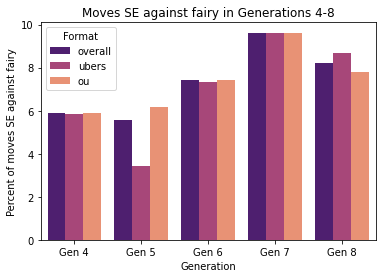

In [26]:
# We make a dataframe based on the result from the calculations above
seFairyDf = pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4','Gen 4', 'Gen 5', 'Gen 5','Gen 5', 'Gen 6', 'Gen 6','Gen 6','Gen 7', 'Gen 7','Gen 7','Gen 8', 'Gen 8', 'Gen 8'],
        "Format": ['overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou','overall', 'ubers', 'ou'],
        "Percent of moves SE against fairy": [gen4SEFairy, gen4SEFairyUbers, gen4SEFairyOU, gen5SEFairy, gen5SEFairyUbers, gen5SEFairyOU, gen6SEFairy, gen6SEFairyUbers, gen6SEFairyOU, gen7SEFairy, gen7SEFairyUbers, gen7SEFairyOU, gen8SEFairy, gen8SEFairyUbers, gen8SEFairyOU],
    },
)

# change decimal into a percentage
seFairyDf["Percent of moves SE against fairy"] = seFairyDf["Percent of moves SE against fairy"].apply(lambda x: x*100)

sns.barplot(x="Generation", 
            y="Percent of moves SE against fairy", 
            hue="Format", 
            data=seFairyDf,
            palette='magma'
           ).set_title("Moves SE against fairy in Generations 4-8")


As we would expect, the number of moves super effective against fairy types increased drastically in Gen 6 with the introduction of fairy types. Players were forced to use steel, and poison type attacks more frequently in order to counter the new fairy pokemon.